In [26]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

from torch.autograd import Variable

import data
from transformer_attention import *

## Overhead

In [27]:
# Training hyperparameters
eval_batch_size = 10
batch_size = 74
seq_len = 18
dropout = 0.1
clip = 1
lr = 1e-5
warmup_steps = 5
decay_factor = 0.65
smoothing = 0.05

epochs = 200
log_interval = 100  # Print log every `log_interval` batches

In [28]:
# Model hyperparameters
embed_size = 256
ff_size = 1024
n_layers = 3
n_heads = 4

In [29]:
# Starting from sequential data, `batchify` arranges the dataset into columns.
# For instance, with the alphabet as the sequence and batch size 4, we'd get
# ┌ a g m s ┐
# │ b h n t │
# │ c i o u │
# │ d j p v │
# │ e k q w │
# └ f l r x ┘.
# These columns are treated as independent by the model, which means that the
# dependence of e. g. 'g' on 'f' can not be learned, but allows more efficient
# batch processing.
# NOTE: modified to emit data as size [batch_size, seq_len]
def batchify(data, batch_size):
    # Work out how cleanly we can divide the dataset into batches
    nbatches = data.size(0) // batch_size
    # Trim off any extra elements that wouldn't cleanly fit
    data = data.narrow(0, 0, nbatches * batch_size)
    # Evenly divide the data across the batches
    data = data.view(batch_size, -1).contiguous()
    return data

# `get_batch` subdivides the source data into chunks of the specified length.
# E.g., using the example for the `batchify` function above and a length of 2,
# we'd get the following two Variables for i = 0:
# ┌ a g m s ┐ ┌ b h n t ┐
# └ b h n t ┘ └ c i o u ┘
# Note that despite the name of the function, the subdivison of data is not
# done along the batch dimension (i.e. dimension 1), since that was handled
# by the `batchify` function. The chunks are along dimension 0, corresponding
# to the `seq_len` dimension in the LSTM.
def get_batch(src, i, seq_len, evaluate = False):
    seq_len = min(seq_len, src.size(1) - 2 - i)
    data = Variable(src[:, i+1 : i+seq_len+1].contiguous(), volatile = evaluate)
    prev = Variable(src[:, i : i+seq_len].contiguous(), volatile = evaluate)
    targets = Variable(src[:, i+2 : i+seq_len+2].contiguous(), volatile = evaluate)
    return data, prev, targets

Label smoothing class for regularization

In [30]:
class LabelSmoothing(nn.Module):
    def __init__(self, size, padding_idx = None, smoothing = 0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss()
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = torch.zeros_like(x.data)
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist.add_(self.smoothing / self.size)
        if self.padding_idx is not None:
            true_dist[:, self.padding_idx] = 0
            mask = torch.nonzero(target.data == self.padding_idx)
            if mask.dim() > 0:
                true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad = False)) * ntokens

Learning rate scheduler that sets the learning rate factor according to:

$$\text{lr} = d_{\text{model}}^{-0.5}\cdot\min{(\text{epoch}^{-0.5}, \text{epoch}\cdot\text{warmup}^{-1.5})}$$

This corresponds to increasing the learning rate linearly for the first $\text{warmup}$ epochs, then decreasing it proportionally to the inverse square root of the epoch number.

In [31]:
def get_lr_scheduler(h_size, warmup, optimizer):
    lrate = lambda e: h_size**(-0.5) * min((e+1)**(-decay_factor), (e+1) * warmup**(-(decay_factor+1)))
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lrate)

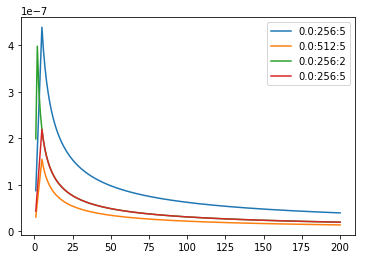

In [32]:
lrate = lambda factor, h_size, warmup: lambda e: factor*(h_size**(-0.5) * min(e**(-decay_factor), e * warmup**(-(decay_factor+1))))
opts = [
    lrate(2*lr, embed_size, warmup_steps), 
    lrate(lr, embed_size*2, warmup_steps),
    lrate(lr, embed_size, warmup_steps//2),
    lrate(lr, embed_size, warmup_steps),
]
plt.plot(np.arange(1, epochs+1), [[opt(i) for opt in opts] for i in range(1, epochs+1)])
plt.legend([
    "%.1f:%d:%d" % (2*lr, embed_size, warmup_steps),
    "%.1f:%d:%d" % (lr, embed_size*2, warmup_steps),
    "%.1f:%d:%d" % (lr, embed_size, warmup_steps//2),
    "%.1f:%d:%d" % (lr, embed_size, warmup_steps),
])

## Initialize data

In [33]:
corpus = data.Corpus('./data/ptb')
ntokens = len(corpus.dictionary)

## Model definition

In [34]:
class TransformerAttentionModel(nn.Module):
    def __init__(self, src_vocab, tgt_vocab, N = 6,
                 embed_size = 512, ff_size = 2048,
                 num_attn_heads = 8, dropout = 0.1):
        super(TransformerAttentionModel, self).__init__()
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.N = N
        self.embed_size = embed_size
        self.ff_size = ff_size
        self.num_attn_heads = num_attn_heads
        
        self.dropout = nn.Dropout(dropout)
        self.src_embedding = nn.Embedding(src_vocab, embed_size)
        self.tgt_embedding = nn.Embedding(tgt_vocab, embed_size)
        self.attn = TransformerAttention(
            src_vocab, tgt_vocab, d_model = embed_size,
            d_ff = ff_size, h = num_attn_heads, N = N,
            dropout = dropout
        )
        self.projection = nn.Linear(embed_size, tgt_vocab)
        self.log_softmax = nn.LogSoftmax(-1)
        
        # Tie all embedding/projection weights
        self.src_embedding.weight = self.projection.weight
        self.tgt_embedding.weight = self.projection.weight
        
    def init(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform(p)
            else:
                p.data.fill_(0)
                
    def forward(self, src, tgt, src_mask = None, tgt_mask = None):
        src_embeddings = self.dropout(self.src_embedding(src))
        tgt_embeddings = self.dropout(self.tgt_embedding(tgt))
        
        attentions = self.attn(src_embeddings, tgt_embeddings, src_mask, tgt_mask)
        
        logits = self.projection(self.dropout(attentions))
        # LabelSmoothing loss requires the model output log-softmax
        outputs = self.log_softmax(logits)
        return outputs

## Initialize model, criterion, optimizer, and learning rate scheduler

In [35]:
model = TransformerAttentionModel(
    ntokens, ntokens, N = n_layers, embed_size = embed_size,
    ff_size = ff_size, num_attn_heads = n_heads, dropout = dropout
)
model.init()
criterion = LabelSmoothing(ntokens, smoothing = smoothing)
optimizer = optim.Adam(
    model.parameters(), lr = lr, betas = (0.9, 0.98), eps = 1e-9
)
lr_scheduler = get_lr_scheduler(embed_size, warmup_steps, optimizer)

In [36]:
nparams = sum([p.numel() for p in model.parameters()])
print('Model parameters: %d' % nparams)

Model parameters: 8100624


## Train
Ready the data

In [12]:
train_data = batchify(corpus.train, batch_size)
val_data = batchify(corpus.valid, eval_batch_size)
test_data = batchify(corpus.test, eval_batch_size)
train_data.size(), val_data.size(), test_data.size()

(torch.Size([74, 12562]), torch.Size([10, 7376]), torch.Size([10, 8243]))

Define training and validation loops

In [13]:
# Training loop
def train():
    # Use random length sequences
    seq_lens = []
    tot_len = 0
    jitter = 0.15 * seq_len
    num_data = train_data.size(1)
    while tot_len < num_data - 2:
        if num_data - tot_len - 2 < seq_len + jitter:
            slen = num_data - tot_len - 2
        else:
            slen = int(np.random.normal(seq_len, jitter))
            if slen <= 0:
                slen = seq_len    # eh
            if tot_len + slen >= num_data - jitter - 2:
                slen = num_data - tot_len - 2
        seq_lens.append(slen)
        tot_len += slen
    # Turn on training mode
    model.train()
    # Pre metainfo
    total_loss = 0
    total_epoch_loss = 0
    start_time = time.time()
    for batch, i in enumerate(np.cumsum(seq_lens)):
        # Get training data
        data, prev, targets = get_batch(train_data, i, seq_lens[batch])
        # Zero out gradients
        model.zero_grad()
        
        # Run the model forward
        output = model(data, prev)
        if np.isnan(output.data).any():
            return 0, total_epoch_loss[0], data, prev, targets
        # Calculate loss
        loss = criterion(output.view(-1, ntokens), targets.view(-1))
        if np.isnan(loss.data[0]):
            return 1, total_epoch_loss[0], data, prev, targets
        # Propagate loss gradient backwards
        loss.backward()
        # Clip gradients
        if batch % log_interval == 0 and batch > 0:
            # Save gradient statistics before they're changed cuz we'll be logging this batch
            parameters = [p for p in model.parameters() if p.grad is not None]
            # Calculate the largest (absolute) gradient of all elements in the model parameters
            max_grad = max([p.grad.data.abs().max() for p in parameters])
        total_norm = nn.utils.clip_grad_norm(model.parameters(), clip)
        # Scale the batch learning rate so that shorter sequences aren't "stronger"
        scaled_lr = lr_scheduler.get_lr()[0] * np.sqrt(seq_lens[batch] / seq_len)
        for param_group in optimizer.param_groups:
            param_group['lr'] = scaled_lr
        # Update parameters
        optimizer.step()
        
        # Metainfo logging
        total_loss += loss.data
        total_epoch_loss += loss.data * data.size(1)
        if batch % log_interval == 0 and batch > 0:
            elapsed = time.time() - start_time
            cur_loss = total_loss[0] / log_interval
            print(' b {:3d}/{:3d} >> {:6.1f} ms/b | lr: {:8.2g} | grad norm: {:4.2f} | max abs grad: {:7.3f} | loss: {:4.2f} | perp.: {:6.2f}'.format(
                batch, len(seq_lens), elapsed * 1000/log_interval, scaled_lr, total_norm, max_grad, cur_loss, np.exp(cur_loss)
            ))
            total_loss = 0
            start_time = time.time()
    return -1, total_epoch_loss[0] / num_data, None, None, None

In [14]:
def evaluate(data_src):
    model.eval()
    total_loss = 0
    for i in range(0, data_src.size(1) - 2, seq_len):
        # Get data
        data, prev, targets = get_batch(data_src, i, seq_len, evaluate = True)
        # Zero out gradients
        model.zero_grad()
        
        # Run model forward
        output = model(data, prev)
        # Calculate loss
        loss = criterion(output.view(-1, ntokens), targets.view(-1))
        total_loss += loss.data * data.size(1)
    return total_loss[0] / (data.size(1) - 2)

In [15]:
WIDTH = 112
CAUSES = ['output', 'grad']
for epoch in range(epochs):
    lr_scheduler.step()
    print('Epoch {:3d}/{:3d}) lr = {:.4g}{}'.format(epoch+1, epochs, np.mean(lr_scheduler.get_lr()[0]), ' (warmup)' if epoch < warmup_steps else ''))
    start_time = time.time()
    stat, train_loss, data, prev, targets = train()
    if stat in list(range(len(CAUSES))):
        c = CAUSES[stat]
        n = (WIDTH - len(c) - 4) // 2
        print('\n' + (' '*n) + 'NaN ' + c)
        break
    elapsed = time.time() - start_time
    val_loss = evaluate(val_data)
    max_param = max([p.data.abs().max() for p in model.parameters() if p.grad is not None])
    print('-' * WIDTH)
    print('Elapsed time: {:6.2f} sec | train_loss: {:5.2f} | train_perp: {:6.2f} | valid_loss: {:5.2f} | valid_perp.: {:6.2f}'.format(
        elapsed, train_loss, np.exp(train_loss), val_loss, np.exp(val_loss)
    ))
    print('Max abs wt: {:5.2f}' % (
        max_param
    ))
    print('=' * WIDTH)
    print('\n')

Epoch   1/200) lr = 4.391e-08 (warmup)

                                                   NaN output


In [16]:
if stat in list(range(len(CAUSES))):
    params = [p for p in model.parameters() if p.grad is not None]
    print(any([np.isnan(p.data).any() for p in params]), any([np.isnan(p.grad.data).any() for p in params]))
    print(max([p.grad.data.abs().max() for p in params]))
    
    src_embeddings = model.src_embedding(data)
    tgt_embeddings = model.tgt_embedding(prev)

    attentions = model.attn(src_embeddings, tgt_embeddings, None, None)

    logits = model.projection(attentions)
    # LabelSmoothing loss requires the model output log-softmax
    outputs = model.log_softmax(logits)
    
    print([
        np.isnan(p.data).any() for p in [src_embeddings, tgt_embeddings, attentions, logits, outputs]
    ])

True False
0.0
[True, True, True, True, True]


In [17]:
src_embeddings

Variable containing:
( 0 ,.,.) = 
         nan         nan         nan  ...          nan         nan         nan
         nan         nan         nan  ...          nan         nan         nan
         nan         nan         nan  ...          nan         nan         nan
                 ...                   ⋱                   ...                
         nan         nan         nan  ...          nan         nan         nan
         nan         nan         nan  ...          nan         nan         nan
         nan         nan         nan  ...          nan         nan         nan

( 1 ,.,.) = 
         nan         nan         nan  ...          nan         nan         nan
         nan         nan         nan  ...          nan         nan         nan
         nan         nan         nan  ...          nan         nan         nan
                 ...                   ⋱                   ...                
  2.2355e-02  4.1228e-03  2.2881e-02  ...   1.0479e-02 -1.7622e-02 -9.9456e-04
    

In [18]:
test_loss = evaluate(test_data)
print('test_loss: {:5.2f} | test_perplexity: {:5.2f}'.format(
    test_loss, np.exp(test_loss)
))

KeyboardInterrupt: 

## Evaluation
Check out the prediction quality

In [ ]:
# Get a random sequence from the generated data starting from whatever point
data, prev, targets = get_batch(test_data, 120, seq_len)
# We'll just look at a few batches
nb = 4
data = data[:nb].contiguous()
prev = prev[:nb].contiguous()
targets = targets[:nb].contiguous()

In [ ]:
# Run the model forward
output = model(data, prev)
# Convert to probabilities
output = output.exp()
# Get the max prob for each step
output_probs, output_idx = output.max(-1)
# Convert these to actual words
output_txt = [corpus.dictionary.idx2word[i] for i in output]
target_txt = [corpus.dictionary.idx2word[i] for i in targets]

In [ ]:
for i in range(nb):
    o_txt = [corpus.dictionary.idx2word[i] for i in output_idx[i]]
    t_txt = [corpus.dictionary.idx2word[i] for i in targets[i]]
    print('Outputs: ', ' '.join(o_txt))
    print('Targets: ', ' '.join(t_txt))
    # Print the output with the targets as words
    # Print the output with the targets as indices
    seqs = torch.cat([targets[i].unsqueeze(0), output_idx[i].unsqueeze(0)], 0)
    # Number incorrectly predicted
    num_incorrect = (targets[i] != output_idx[i]).sum()
    print('%d incorrectly predicted\n' % num_incorrect[0], seqs)

## Visualizations

In [ ]:
modules = list(model.modules())
list(enumerate(modules))

In [ ]:
attn_module = modules[4]

Visualize attention weights for the first sequence:

**Encoder attention weights**

In [ ]:
for layer in range(n_layers):
    cols = 4
    rows = n_heads//cols
    fig, axs = plt.subplots(rows, cols, figsize = (20, 10))
    wts = attn_module.encoder_stack[layer].attn.attn.data[:seq_len]
    wts_mean = wts.mean()
    wts_max = wts.max()
    wts_min = wts.min()
    norm = (wts - wts_mean) / (wts_max - wts_min)
    print("\nEncoder layer %d (mean = %g, min = %g, max = %g)" % (layer+1, wts_mean, wts_min, wts_max))
    for h in range(n_heads):
        r = h // cols
        c = h % cols
        ax = axs[r, c]
        ax.imshow(norm[0, h], aspect = 'auto', cmap = 'jet')
        # Fix labels
        s = list(targets[0].data)
        ax.set_xticks(range(seq_len))
        ax.set_xticklabels(s if r == rows-1 else [])
        ax.set_yticks(range(seq_len))
        ax.set_yticklabels(s if c == 0 else [])
    plt.show()

**Decoder self-attention weights**

In [ ]:
for layer in range(n_layers):
    cols = 4
    rows = n_heads//cols
    # Self-attention weights
    fig, axs = plt.subplots(rows, cols, figsize = (20, 10))
    wts = attn_module.decoder_stack[layer].self_attn.attn.data[:seq_len]
    wts_mean = wts.mean()
    wts_max = wts.max()
    wts_min = wts.min()
    norm = (wts - wts_mean) / (wts_max - wts_min)
    print("\nDecoder self-attention %d (mean = %g, min = %g, max = %g)" % (layer+1, wts_mean, wts_min, wts_max))
    for h in range(n_heads):
        r = h // cols
        c = h % cols
        ax = axs[r, c]
        ax.imshow(norm[0, h], aspect = 'auto', cmap = 'jet')
        # Fix labels
        s = list(targets[0].data)
        ax.set_xticks(range(seq_len))
        ax.set_xticklabels(s if r == rows-1 else [])
        ax.set_yticks(range(seq_len))
        ax.set_yticklabels(s if c == 0 else [])
    plt.show()

**Decoder source-attention weights**

In [ ]:
for layer in range(n_layers):
    cols = 4
    rows = n_heads//cols
    # Self-attention weights
    fig, axs = plt.subplots(rows, cols, figsize = (20, 10))
    wts = attn_module.decoder_stack[layer].src_attn.attn.data[:seq_len]
    wts_mean = wts.mean()
    wts_max = wts.max()
    wts_min = wts.min()
    norm = (wts - wts_mean) / (wts_max - wts_min)
    print("\nDecoder src-attention %d (mean = %g, min = %g, max = %g)" % (layer+1, wts_mean, wts_min, wts_max))
    for h in range(n_heads):
        r = h // cols
        c = h % cols
        ax = axs[r, c]
        ax.imshow(norm[0, h], aspect = 'auto', cmap = 'jet')
        # Fix labels
        s = list(targets[0].data)
        ax.set_xticks(range(seq_len))
        ax.set_xticklabels(s if r == rows-1 else [])
        ax.set_yticks(range(seq_len))
        ax.set_yticklabels(s if c == 0 else [])
    plt.show()